# <b>Assignment : DT</b>

# Task1

# Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.multioutput import MultiOutputClassifier
import seaborn as snc
from sklearn.tree import DecisionTreeClassifier
import re


import pickle
from tqdm import tqdm
import os



from collections import Counter

## 1.1 Loading Data

In [3]:
data  = pd.read_csv('preprocessed_data.csv', nrows=50000)
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [4]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [5]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import nltk
nltk.download('vader_lexicon')

# this is the function to calculate the sentiment score for any features
def sentiment_score(X,feature):

# initilaze the list for the negative, positive, neutral, and compound score
  neg=[]
  neu=[]
  pos=[]
  compound=[]

# for different datapoints of X calculate the score and append them into the various lists initialized
  sid = SentimentIntensityAnalyzer()
  for i in range(len(X)):
    for_sentiment = X[feature].iloc[i]
    ss = sid.polarity_scores(for_sentiment)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    compound.append(ss['compound'])
  return np.asarray(neg).reshape(-1,1),np.asarray(neu).reshape(-1,1),np.asarray(pos).reshape(-1,1),np.asarray(compound).reshape(-1,1)

# we have to calculate the score for the feature essay
negative,neutral,postive,compound = sentiment_score(X,"essay")
X["sen_neg"]=negative
X["sen_pos"]=postive
X["sen_neu"]=neutral
X["sen_comp"]=compound

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [6]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

# Vectorizing the categorical features

In [7]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)

X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print(X_train_state_ohe.shape)
print(X_cv_state_ohe.shape)
print(X_test_state_ohe.shape)

(22445, 51)
(11055, 51)
(16500, 51)


In [8]:
vectorizer= CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)
X_train_teacher_prefix_ohe =vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_prefix_ohe =vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_prefix_ohe = vectorizer.transform(X_test['teacher_prefix'])

print(X_train_teacher_prefix_ohe.shape)
print(X_cv_teacher_prefix_ohe.shape)
print(X_test_teacher_prefix_ohe.shape)

(22445, 5)
(11055, 5)
(16500, 5)


In [9]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)
X_train_project_grade_category_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_project_grade_category_ohe= vectorizer.transform(X_cv['project_grade_category'].values)
X_test_project_grade_category_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print(X_train_project_grade_category_ohe.shape)
print(X_cv_project_grade_category_ohe.shape)
print(X_test_project_grade_category_ohe.shape)

(22445, 4)
(11055, 4)
(16500, 4)


In [10]:
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

In [11]:
vectorizer= CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)
X_train_clean_categories_ohe =vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_categories_ohe =vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'])

print(X_train_clean_categories_ohe.shape)
print(X_cv_clean_categories_ohe.shape)
print(X_test_clean_categories_ohe.shape)


(22445, 7)
(11055, 7)
(16500, 7)


In [12]:
vectorizer= CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)
X_train_clean_subcategories_ohe =vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategories_ohe =vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'])

print(X_train_clean_subcategories_ohe.shape)
print(X_cv_clean_subcategories_ohe.shape)
print(X_test_clean_subcategories_ohe.shape)

(22445, 28)
(11055, 28)
(16500, 28)


# Vectorizing the numerical features

In [13]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_pre= normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_pre = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_pre = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print(X_train_pre.shape)
print(X_cv_pre.shape)
print(X_test_pre.shape)

(22445, 1)
(11055, 1)
(16500, 1)


In [14]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price= normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price = normalizer.transform(X_test['price'].values.reshape(-1,1))
X_cv_price = normalizer.transform(X_cv['price'].values.reshape(-1,1))

print(X_train_price.shape)
print(X_cv_price.shape)
print(X_test_price.shape)

(22445, 1)
(11055, 1)
(16500, 1)


# Vectorizing the text data with tfidf

In [15]:
vectorizer_tfidf = TfidfVectorizer(min_df=10)
vectorizer_tfidf.fit(X_train['essay'].values)
X_train_essay_tfidf_ohe = vectorizer_tfidf.transform(X_train['essay'].values)
X_cv_essay_tfidf_ohe = vectorizer_tfidf.transform(X_cv['essay'].values)
X_test_essay_tfidf_ohe = vectorizer_tfidf.transform(X_test['essay'].values)

print(X_train_essay_tfidf_ohe.shape)
print(X_cv_essay_tfidf_ohe.shape)
print(X_test_essay_tfidf_ohe.shape)

(22445, 8807)
(11055, 8807)
(16500, 8807)


# Vectorizing the text data with tfidfw2v

In [16]:

import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [17]:
X_train_vectorizer = TfidfVectorizer()
X_train_vectorizer.fit(X_train['essay'].values)



TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [18]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(X_train_vectorizer.get_feature_names(), list(X_train_vectorizer.idf_)))
tfidf_words_train = set(X_train_vectorizer.get_feature_names())

In [19]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_train):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary_train[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|██████████| 22445/22445 [00:47<00:00, 468.59it/s]

22445
300


In [20]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_train):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary_train[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))

100%|██████████| 11055/11055 [00:23<00:00, 467.29it/s]

11055
300


In [21]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_train):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary_train[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|██████████| 16500/16500 [00:35<00:00, 466.70it/s]

16500
300


# Sentiment score for essay

In [22]:
ss_neg_train = np.array(X_train['sen_neg']).reshape(-1,1)
ss_pos_train= np.array(X_train['sen_pos']).reshape(-1,1)
ss_neu_train = np.array(X_train['sen_neu']).reshape(-1,1)
ss_com_train = np.array(X_train['sen_comp']).reshape(-1,1)

In [23]:
ss_neg_cv = np.array(X_cv['sen_neg']).reshape(-1,1)
ss_pos_cv= np.array(X_cv['sen_pos']).reshape(-1,1)
ss_neu_cv = np.array(X_cv['sen_neu']).reshape(-1,1)
ss_com_cv = np.array(X_cv['sen_comp']).reshape(-1,1)

In [24]:
ss_neg_test = np.array(X_test['sen_neg']).reshape(-1,1)
ss_pos_test= np.array(X_test['sen_pos']).reshape(-1,1)
ss_neu_test= np.array(X_test['sen_neu']).reshape(-1,1)
ss_com_test= np.array(X_test['sen_comp']).reshape(-1,1)

# **Set1**

In [25]:
# use hstack to combine the all vectorized features with tfidf vectorizer for train, test and cv

from scipy.sparse import hstack
X_tfidf_tr = hstack((X_train_state_ohe,
               X_train_teacher_prefix_ohe,
               X_train_project_grade_category_ohe,
               X_train_clean_categories_ohe,
               X_train_clean_subcategories_ohe,
               X_train_pre,
               X_train_price,
               X_train_essay_tfidf_ohe,
               ss_neg_train,
               ss_pos_train,
               ss_neu_train,
               ss_com_train
               )).toarray()


               

In [26]:
X_tfidf_cv = hstack((X_cv_state_ohe,
               X_cv_teacher_prefix_ohe,
               X_cv_project_grade_category_ohe,
               X_cv_clean_categories_ohe,
               X_cv_clean_subcategories_ohe,
               X_cv_pre,
               X_cv_price,
               X_cv_essay_tfidf_ohe,
               ss_neg_cv,
               ss_pos_cv,
               ss_neu_cv,
               ss_com_cv
               )).toarray()

In [27]:
X_tfidf_te = hstack((X_test_state_ohe,
               X_test_teacher_prefix_ohe,
               X_test_project_grade_category_ohe,
               X_test_clean_categories_ohe,
               X_test_clean_subcategories_ohe,
               X_test_pre,
               X_test_price,
               X_test_essay_tfidf_ohe,
               ss_neg_test,
               ss_pos_test,
               ss_neu_test,
               ss_com_test
               )).toarray()

In [28]:
# apply DecisionTree on this set1 of the featutres
clf = DecisionTreeClassifier()
clf.fit(X_tfidf_tr, y_train)
# predict the classes for the all train datapoints
y_tfidf_pred = clf.predict(X_tfidf_te)
#calculate the accuracy for the test data points
accuracy =metrics.accuracy_score(y_test, y_tfidf_pred)

print(accuracy)

0.7440606060606061


# **Set2**

In [29]:
from scipy.sparse import hstack


# now prepare the set2 of the features of the tfidf_w2v with the hstack
X_w2v_tr = hstack((X_train_state_ohe,
               X_train_teacher_prefix_ohe,
               X_train_project_grade_category_ohe,
               X_train_clean_categories_ohe,
               X_train_clean_subcategories_ohe,
               X_train_pre,
               X_train_price,
               tfidf_w2v_vectors_train,
               ss_neg_train,
               ss_pos_train,
               ss_neu_train,
               ss_com_train
               ))

In [30]:
X_w2v_cv = hstack((X_cv_state_ohe,
               X_cv_teacher_prefix_ohe,
               X_cv_project_grade_category_ohe,
               X_cv_clean_categories_ohe,
               X_cv_clean_subcategories_ohe,
               X_cv_pre,
               X_cv_price,
               tfidf_w2v_vectors_cv,
               ss_neg_cv,
               ss_pos_cv,
               ss_neu_cv,
               ss_com_cv
               ))

In [31]:
X_w2v_te = hstack((X_test_state_ohe,
               X_test_teacher_prefix_ohe,
               X_test_project_grade_category_ohe,
               X_test_clean_categories_ohe,
               X_test_clean_subcategories_ohe,
               X_test_pre,
               X_test_price,
               tfidf_w2v_vectors_test,
               ss_neg_test,
               ss_pos_test,
               ss_neu_test,
               ss_com_test
               ))

In [32]:
# apply the decision tree on this set 2 
clf = DecisionTreeClassifier()
clf.fit(X_w2v_tr, y_train)
# predict the class label for the train data
y_w2v_pred= clf.predict(X_w2v_te)


# calculate the accuracy for the test data points
accuracy =metrics.accuracy_score(y_test, y_w2v_pred)

print(accuracy)

0.7344242424242424


# Hyperparameter tuning

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


# now we will do the hyperparameter tuning for the parameters 

param = {'max_depth':[1,5,10,50], 'min_samples_split':[5,10,100,500]}

# take the classifier as the Decision Tree classifier 
classifier = DecisionTreeClassifier()
model = GridSearchCV(classifier, param_grid=param,return_train_score=True)
model.fit(X_tfidf_tr, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50],
                     

# Heatmap

In [34]:
# by our above model take the all cv_results in results variable
results = model.cv_results_

In [35]:
# make the dataframe with this results
results = pd.DataFrame(results)
# sort the all values with respect to the mean_test_score column and keep ascending= False
results=results.sort_values(by=['mean_test_score'], ascending=False)

In [36]:
# take the three varible depth, min_sample and score to store the values of the columns param_max_depth , param_min_sample_split and mean_test_score respectively
depth = results['param_max_depth']
min_sample = results['param_min_samples_split']
score = results['mean_test_score']

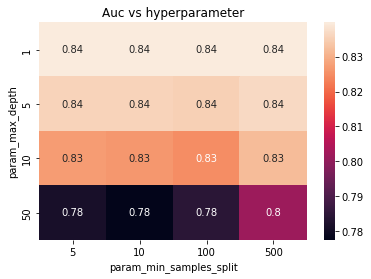

In [37]:
df = results[['param_max_depth','param_min_samples_split','mean_test_score']]
 
# now make a dataframe with the pivot table and apply the heatmap on this dataframe
df = pd.pivot_table(df,values='mean_test_score', columns='param_min_samples_split', index='param_max_depth')
df= sns.heatmap(df,annot=True)
plt.title('Auc vs hyperparameter')
plt.show()

# Apply the Decision Tree with the best hyperparameters on set1 and set2

In [38]:
clf_tfidf = DecisionTreeClassifier(max_depth=1, min_samples_split=10)
clf_tfidf.fit(X_tfidf_tr, y_train)

# do the prediction for the set 1 train and test data
y_tfidf_tr_pred = clf_tfidf.predict(X_tfidf_tr)
y_tfidf_te_pred = clf_tfidf.predict(X_tfidf_te)

# calculate the accuracy score for the test data
accuracy_1 =metrics.accuracy_score(y_test, y_tfidf_te_pred)

print(accuracy_1)

0.8398787878787879


In [39]:
clf_w2v = DecisionTreeClassifier(max_depth=1, min_samples_split=10)
clf_w2v.fit(X_w2v_tr, y_train)

# do same for the set 2  train and test data
y_w2v_tr_pred = clf_w2v.predict(X_w2v_tr)
y_w2v_te_pred= clf_w2v.predict(X_w2v_te)

# calculate the accuracy for the set 2 test data
accuracy_2 =metrics.accuracy_score(y_test, y_w2v_pred)

print(accuracy_2)

0.7344242424242424


# Plot the ROC curve for the set 1 and set 2

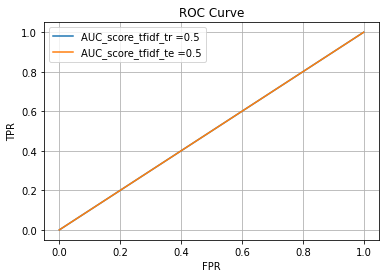

In [40]:
# calculate the fpr, tpr for the set 1 train and test data with the function roc_curve
fpr_tfidf_tr,tpr_tfidf_tr, threshold_tfidf = roc_curve(y_train,y_tfidf_tr_pred)
fpr_tfidf_te,tpr_tfidf_te, threshold_te = roc_curve(y_test, y_tfidf_te_pred)
# calculate the AUC score
Auc_tfidf_tr = str(auc(fpr_tfidf_tr, tpr_tfidf_tr))
# plot the ROC curve 
plt.plot(fpr_tfidf_tr,tpr_tfidf_tr, label="AUC_score_tfidf_tr ="+str(auc(fpr_tfidf_tr, tpr_tfidf_tr)))
plt.plot(fpr_tfidf_te, tpr_tfidf_te, label="AUC_score_tfidf_te ="+str(auc(fpr_tfidf_te, tpr_tfidf_te)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

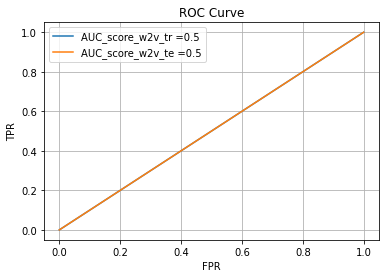

In [41]:
# calculate the fpr and tpr for the set 2
fpr_w2v_tr, tpr_w2v_tr, threshold_tr = roc_curve(y_train, y_w2v_tr_pred)
fpr_w2v_te, tpr_w2v_te, threshold_te = roc_curve(y_test, y_w2v_te_pred)

# calculate the AUC score 
Auc_w2v_tr = str(auc(fpr_w2v_tr, tpr_w2v_tr))
# plot the ROC curve 
plt.plot(fpr_w2v_tr,tpr_w2v_tr, label="AUC_score_w2v_tr ="+str(auc(fpr_w2v_tr, tpr_w2v_tr)))
plt.plot(fpr_w2v_te, tpr_w2v_te, label="AUC_score_w2v_te ="+str(auc(fpr_w2v_te, tpr_w2v_te)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

# Plot the confusion matrix

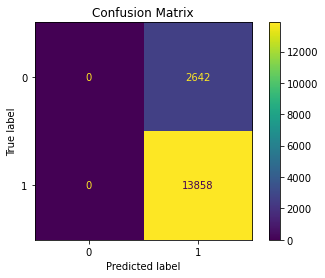

In [42]:
plot_confusion_matrix(clf_tfidf,X_tfidf_te,y_test,values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Collect all the false positive points 

In [43]:
false_positive= np.logical_and(y_test!=y_tfidf_te_pred, y_tfidf_te_pred==1)
FP_X_test=X_test[false_positive]

# Wordcloud for the text of the essay of these false positive points

In [44]:
false_pos =FP_X_test['essay']

In [45]:
text= " ".join(str(ele) for ele in false_pos)

In [46]:
!pip install wordcloud

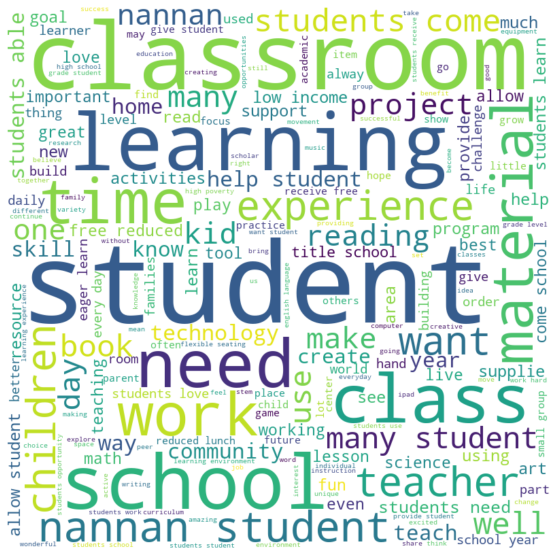

In [47]:
from wordcloud import WordCloud,STOPWORDS

stopwords= set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)


plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Boxplot for the price for the false positive points

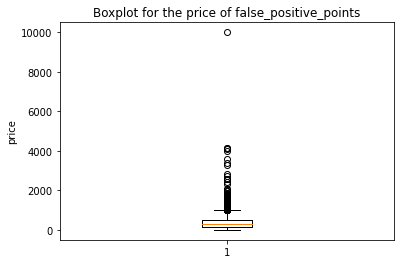

In [48]:
plt.boxplot(FP_X_test["price"],)
plt.ylabel('price')
plt.title('Boxplot for the price of false_positive_points')
plt.show()

# Pdf for the Teacher_number_of_previously_posted_projects

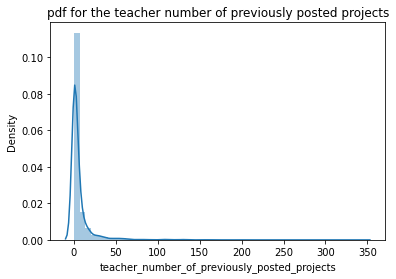

In [49]:
sns.distplot(FP_X_test['teacher_number_of_previously_posted_projects'])
plt.title('pdf for the teacher number of previously posted projects')
plt.show()

# Task2

In [50]:
clf_ = DecisionTreeClassifier(max_depth= None, min_samples_split=10, class_weight='balanced')
clf_.fit(X_tfidf_tr,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [51]:
# by using the function feature_importance_ take take the feature importance of the features
feature_importance=clf_.feature_importances_
# now collect the all indices of the features heving non zero indices
feature_indices= np.where(feature_importance!=0)[0]

In [52]:
X_tfidf_tr= X_tfidf_tr[:,feature_indices]
X_tfidf_te= X_tfidf_te[:,feature_indices]
X_tfidf_cv= X_tfidf_cv[:,feature_indices]

In [53]:
# now we will do the hyperparameter tuning for the parameters 


param = {'max_depth':[1,5,10,50], 'min_samples_split':[5,10,100,500]}

# take the classifier as the Decision Tree classifier 
classifier = DecisionTreeClassifier()
model = GridSearchCV(classifier, param_grid=param, return_train_score=True)
# keep the return_train_score = True
model.fit(X_tfidf_tr,y_train)
# fit the model and print the best parameters
best_parameter=model.best_params_
print(best_parameter)

{'max_depth': 1, 'min_samples_split': 5}


In [54]:
clf = DecisionTreeClassifier(max_depth=1, min_samples_split=5)
clf.fit(X_tfidf_tr,y_train)

pred=clf.predict(X_tfidf_te)

accuracy_3 =metrics.accuracy_score(y_test, pred) 
print(accuracy_3)

0.8398787878787879


# Results

In [55]:
from prettytable import PrettyTable

table =PrettyTable(['vectorizer', 'model', 'hyperparameter', 'accuracy'])
table.add_row(['tfidf', 'DT','max_depth=1,sample_split=10',accuracy_1])
table.add_row(['w2v', 'DT','max_depth=1,sample_split=10',accuracy_2])
table.add_row(['tfidf', 'DT','max_depth=1,sample_split=5',accuracy_3])
print(table)

+------------+-------+-----------------------------+--------------------+
| vectorizer | model |        hyperparameter       |      accuracy      |
+------------+-------+-----------------------------+--------------------+
|   tfidf    |   DT  | max_depth=1,sample_split=10 | 0.8398787878787879 |
|    w2v     |   DT  | max_depth=1,sample_split=10 | 0.7344242424242424 |
|   tfidf    |   DT  |  max_depth=1,sample_split=5 | 0.8398787878787879 |
+------------+-------+-----------------------------+--------------------+
